In [4]:
# Cell 1: Import libraries and read data
import pandas as pd
import numpy as np
from datetime import datetime

# Read the Excel file
df = pd.read_excel('shadowhistory.xlsx')

# Clean the Profit column - remove spaces and convert to float
df['Profit'] = df['Profit'].str.replace(' ', '').astype(float)

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
df.info()
print("\nFirst few rows:")
print("-" * 50)
display(df.head())

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5809 entries, 0 to 5808
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Ticket      5809 non-null   int64  
 1   Open Time   5809 non-null   object 
 2   Type        5809 non-null   object 
 3   Size        5809 non-null   float64
 4   Item        5809 non-null   object 
 5   Price       5809 non-null   float64
 6   S / L       5809 non-null   float64
 7   T / P       5809 non-null   float64
 8   Close Time  5809 non-null   object 
 9   Price.1     5809 non-null   float64
 10  Commission  5809 non-null   float64
 11  Taxes       5809 non-null   int64  
 12  Swap        5809 non-null   int64  
 13  Profit      17 non-null     float64
dtypes: float64(7), int64(3), object(4)
memory usage: 635.5+ KB

First few rows:
--------------------------------------------------


,Ticket,Open Time,Type,Size,Item,Price,S / L,T / P,Close Time,Price.1,Commission,Taxes,Swap,Profit
0,85402302,2024.04.22 03:30:00,sell,0.01,audcad,0.88434,1.08434,0.88335,2024.04.22 08:00:32,0.88335,-0.06,0,0,NaN
1,85462631,2024.04.23 04:15:51,sell,0.01,audcad,0.88434,1.08434,0.88335,2024.04.23 10:18:45,0.88335,-0.06,0,0,NaN
2,85477664,2024.04.23 17:00:00,sell,0.01,audcad,0.88562,1.08562,0.89030,2024.04.25 15:46:09,0.89032,-0.06,0,0,NaN
3,85486572,2024.04.24 04:46:34,sell,0.02,audcad,0.89026,1.08562,0.89030,2024.04.25 15:46:09,0.89032,-0.12,0,0,NaN
4,85511782,2024.04.25 11:01:52,sell,0.03,audcad,0.89236,1.08562,0.89030,2024.04.25 15:46:09,0.89032,-0.18,0,0,NaN


In [5]:
# Cell 2: Analysis functions and main processing
def get_level(size):
    """Convert lot size to strategy level"""
    if size <= 0.04:
        return round(size / 0.01)  # For sizes 0.01, 0.02, 0.03, 0.04
    else:
        return round((size * 10))  # For sizes 0.5, 0.6, etc.

def analyze_trading_levels(df):
    """Analyzes trading levels based on lot sizes for each currency pair"""    
    # Add level column
    df['Level'] = df['Size'].apply(get_level)
    
    results = {}
    overall_stats = {
        'buy_levels': {},
        'sell_levels': {},
        'total_trades': 0,
        'total_profit': 0,
        'max_level_reached': 0
    }
    
    # Analyze each currency pair
    for pair in df['Item'].unique():
        pair_df = df[df['Item'] == pair]
        
        # Separate buy and sell trades
        buy_df = pair_df[pair_df['Type'] == 'buy']
        sell_df = pair_df[pair_df['Type'] == 'sell']
        
        # Count levels for each type
        buy_levels = buy_df['Level'].value_counts().sort_index()
        sell_levels = sell_df['Level'].value_counts().sort_index()
        
        # Calculate trade statistics
        stats = {
            'total_trades': len(pair_df),
            'buy_trades': len(buy_df),
            'sell_trades': len(sell_df),
            'total_profit': pair_df['Profit'].sum(),
            'avg_profit': pair_df['Profit'].mean(),
            'max_level_reached': pair_df['Level'].max(),
            'avg_trade_duration': (pd.to_datetime(pair_df['Close Time']) - 
                                 pd.to_datetime(pair_df['Open Time'])).mean(),
            'profit_by_level': pair_df.groupby('Level')['Profit'].agg(['sum', 'mean', 'count']).round(2),
            'win_rate': (pair_df['Profit'] > 0).mean() * 100
        }
        
        results[pair] = {
            'buy_levels': buy_levels.to_dict(),
            'sell_levels': sell_levels.to_dict(),
            'statistics': stats
        }
        
        # Update overall statistics
        overall_stats['total_trades'] += stats['total_trades']
        overall_stats['total_profit'] += stats['total_profit']
        overall_stats['max_level_reached'] = max(overall_stats['max_level_reached'], stats['max_level_reached'])
        
        # Update overall level counts
        for level, count in buy_levels.items():
            overall_stats['buy_levels'][level] = overall_stats['buy_levels'].get(level, 0) + count
        for level, count in sell_levels.items():
            overall_stats['sell_levels'][level] = overall_stats['sell_levels'].get(level, 0) + count
    
    results['OVERALL'] = overall_stats
    return results

# Process the data
results = analyze_trading_levels(df)

In [6]:
# Cell 3: Print detailed analysis
def print_analysis(results):
    """Prints formatted analysis results"""
    print("=== TRADING LEVEL ANALYSIS ===\n")
    
    # Print individual pair analysis
    for pair, data in results.items():
        if pair == 'OVERALL':
            continue
            
        print(f"\n{pair} Analysis:")
        print("-" * 60)
        
        stats = data['statistics']
        
        print(f"\nTotal Trades: {stats['total_trades']}")
        print(f"Buy/Sell Ratio: {stats['buy_trades']}/{stats['sell_trades']}")
        print(f"Total Profit: {stats['total_profit']:.2f}")
        print(f"Win Rate: {stats['win_rate']:.2f}%")
        print(f"Max Level Reached: {stats['max_level_reached']}")
        print(f"Average Trade Duration: {stats['avg_trade_duration']}")
        
        print("\nBUY Levels:")
        for level, count in sorted(data['buy_levels'].items()):
            print(f"Level {level}: {count} times")
            
        print("\nSELL Levels:")
        for level, count in sorted(data['sell_levels'].items()):
            print(f"Level {level}: {count} times")
        
        print("\nProfit Analysis by Level:")
        display(stats['profit_by_level'])
        print("\n" + "=" * 60)
    
    # Print overall statistics
    overall = results['OVERALL']
    print("\nOVERALL STATISTICS:")
    print("-" * 60)
    print(f"Total Trades Across All Pairs: {overall['total_trades']}")
    print(f"Total Profit Across All Pairs: {overall['total_profit']:.2f}")
    print(f"Maximum Level Reached: {overall['max_level_reached']}")
    
    print("\nOverall BUY Levels:")
    for level, count in sorted(overall['buy_levels'].items()):
        print(f"Level {level}: {count} times")
        
    print("\nOverall SELL Levels:")
    for level, count in sorted(overall['sell_levels'].items()):
        print(f"Level {level}: {count} times")

# Print the analysis
print_analysis(results)

=== TRADING LEVEL ANALYSIS ===


audcad Analysis:
------------------------------------------------------------

Total Trades: 334
Buy/Sell Ratio: 170/164
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 6
Average Trade Duration: 0 days 15:34:20.862275449

BUY Levels:
Level 1: 121 times
Level 2: 35 times
Level 3: 10 times
Level 4: 3 times
Level 5: 1 times

SELL Levels:
Level 1: 116 times
Level 2: 32 times
Level 3: 9 times
Level 4: 3 times
Level 5: 3 times
Level 6: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0




audchf Analysis:
------------------------------------------------------------

Total Trades: 235
Buy/Sell Ratio: 138/97
Total Profit: 1174.35
Win Rate: 0.43%
Max Level Reached: 12
Average Trade Duration: 1 days 15:19:08.285106382

BUY Levels:
Level 1: 91 times
Level 2: 27 times
Level 3: 10 times
Level 4: 2 times
Level 5: 1 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times
Level 9: 1 times
Level 10: 1 times
Level 11: 1 times
Level 12: 1 times

SELL Levels:
Level 1: 66 times
Level 2: 16 times
Level 3: 6 times
Level 4: 2 times
Level 5: 2 times
Level 6: 2 times
Level 7: 1 times
Level 8: 1 times
Level 9: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.00,NaN,0
2,0.00,NaN,0
3,0.00,NaN,0
4,0.00,NaN,0
5,0.00,NaN,0
6,0.00,NaN,0
7,0.00,NaN,0
8,0.00,NaN,0
9,0.00,NaN,0




audnzd Analysis:
------------------------------------------------------------

Total Trades: 284
Buy/Sell Ratio: 138/146
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 8
Average Trade Duration: 0 days 20:53:37.049295774

BUY Levels:
Level 1: 102 times
Level 2: 20 times
Level 3: 10 times
Level 4: 2 times
Level 5: 1 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times

SELL Levels:
Level 1: 106 times
Level 2: 28 times
Level 3: 8 times
Level 4: 2 times
Level 5: 1 times
Level 6: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0
8,0.0,NaN,0




audusd Analysis:
------------------------------------------------------------

Total Trades: 305
Buy/Sell Ratio: 165/140
Total Profit: 1909.20
Win Rate: 0.33%
Max Level Reached: 12
Average Trade Duration: 0 days 21:21:42.701639344

BUY Levels:
Level 1: 115 times
Level 2: 27 times
Level 3: 10 times
Level 4: 3 times
Level 5: 2 times
Level 6: 2 times
Level 7: 1 times
Level 8: 1 times
Level 9: 1 times
Level 10: 1 times
Level 11: 1 times
Level 12: 1 times

SELL Levels:
Level 1: 102 times
Level 2: 28 times
Level 3: 5 times
Level 4: 2 times
Level 5: 1 times
Level 6: 1 times
Level 7: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0
8,0.0,NaN,0
9,0.0,NaN,0




cadchf Analysis:
------------------------------------------------------------

Total Trades: 221
Buy/Sell Ratio: 120/101
Total Profit: 4320.84
Win Rate: 1.81%
Max Level Reached: 17
Average Trade Duration: 2 days 08:12:19.538461538

BUY Levels:
Level 1: 68 times
Level 2: 23 times
Level 3: 8 times
Level 4: 4 times
Level 5: 3 times
Level 6: 2 times
Level 7: 2 times
Level 8: 1 times
Level 9: 1 times
Level 10: 1 times
Level 11: 1 times
Level 12: 1 times
Level 13: 1 times
Level 14: 1 times
Level 15: 1 times
Level 16: 1 times
Level 17: 1 times

SELL Levels:
Level 1: 70 times
Level 2: 20 times
Level 3: 6 times
Level 4: 2 times
Level 5: 1 times
Level 6: 1 times
Level 7: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.00,NaN,0
2,0.00,NaN,0
3,0.00,NaN,0
4,0.00,NaN,0
5,-1167.18,-1167.18,1
6,-1236.58,-1236.58,1
7,-1243.18,-1243.18,1
8,-1202.05,-1202.05,1
9,0.00,NaN,0




euraud Analysis:
------------------------------------------------------------

Total Trades: 342
Buy/Sell Ratio: 164/178
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 5
Average Trade Duration: 0 days 04:17:28.195906432

BUY Levels:
Level 1: 139 times
Level 2: 21 times
Level 3: 4 times

SELL Levels:
Level 1: 147 times
Level 2: 22 times
Level 3: 5 times
Level 4: 3 times
Level 5: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0




eurcad Analysis:
------------------------------------------------------------

Total Trades: 302
Buy/Sell Ratio: 137/165
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 7
Average Trade Duration: 1 days 00:17:53.364238410

BUY Levels:
Level 1: 104 times
Level 2: 19 times
Level 3: 7 times
Level 4: 3 times
Level 5: 2 times
Level 6: 1 times
Level 7: 1 times

SELL Levels:
Level 1: 121 times
Level 2: 27 times
Level 3: 9 times
Level 4: 3 times
Level 5: 2 times
Level 6: 2 times
Level 7: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0




eurchf Analysis:
------------------------------------------------------------

Total Trades: 341
Buy/Sell Ratio: 184/157
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 7
Average Trade Duration: 0 days 19:26:46.944281524

BUY Levels:
Level 1: 130 times
Level 2: 31 times
Level 3: 12 times
Level 4: 6 times
Level 5: 4 times
Level 6: 1 times

SELL Levels:
Level 1: 108 times
Level 2: 29 times
Level 3: 9 times
Level 4: 6 times
Level 5: 3 times
Level 6: 1 times
Level 7: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0




eurgbp Analysis:
------------------------------------------------------------

Total Trades: 197
Buy/Sell Ratio: 103/94
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 7
Average Trade Duration: 2 days 05:54:54.005076142

BUY Levels:
Level 1: 66 times
Level 2: 23 times
Level 3: 7 times
Level 4: 4 times
Level 5: 2 times
Level 6: 1 times

SELL Levels:
Level 1: 65 times
Level 2: 19 times
Level 3: 4 times
Level 4: 2 times
Level 5: 2 times
Level 6: 1 times
Level 7: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0




eurnzd Analysis:
------------------------------------------------------------

Total Trades: 234
Buy/Sell Ratio: 139/95
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 4
Average Trade Duration: 0 days 05:24:44.833333333

BUY Levels:
Level 1: 111 times
Level 2: 25 times
Level 3: 2 times
Level 4: 1 times

SELL Levels:
Level 1: 71 times
Level 2: 18 times
Level 3: 5 times
Level 4: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0




eurusd Analysis:
------------------------------------------------------------

Total Trades: 333
Buy/Sell Ratio: 174/159
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 4
Average Trade Duration: 0 days 12:58:10.771771771

BUY Levels:
Level 1: 140 times
Level 2: 26 times
Level 3: 5 times
Level 4: 3 times

SELL Levels:
Level 1: 127 times
Level 2: 23 times
Level 3: 8 times
Level 4: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0




gbpaud Analysis:
------------------------------------------------------------

Total Trades: 168
Buy/Sell Ratio: 72/96
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 11
Average Trade Duration: 0 days 13:24:38.375000

BUY Levels:
Level 1: 66 times
Level 2: 6 times

SELL Levels:
Level 1: 69 times
Level 2: 10 times
Level 3: 3 times
Level 4: 2 times
Level 5: 2 times
Level 6: 2 times
Level 7: 2 times
Level 8: 2 times
Level 9: 2 times
Level 10: 1 times
Level 11: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0
8,0.0,NaN,0
9,0.0,NaN,0




gbpcad Analysis:
------------------------------------------------------------

Total Trades: 243
Buy/Sell Ratio: 107/136
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 8
Average Trade Duration: 0 days 19:31:06.403292181

BUY Levels:
Level 1: 67 times
Level 2: 18 times
Level 3: 8 times
Level 4: 6 times
Level 5: 4 times
Level 6: 2 times
Level 7: 1 times
Level 8: 1 times

SELL Levels:
Level 1: 108 times
Level 2: 15 times
Level 3: 5 times
Level 4: 3 times
Level 5: 2 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0
8,0.0,NaN,0




gbpchf Analysis:
------------------------------------------------------------

Total Trades: 327
Buy/Sell Ratio: 168/159
Total Profit: 2109.17
Win Rate: 0.31%
Max Level Reached: 9
Average Trade Duration: 0 days 22:13:17.948012232

BUY Levels:
Level 1: 122 times
Level 2: 28 times
Level 3: 9 times
Level 4: 3 times
Level 5: 2 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times
Level 9: 1 times

SELL Levels:
Level 1: 118 times
Level 2: 25 times
Level 3: 9 times
Level 4: 4 times
Level 5: 2 times
Level 6: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.00,NaN,0
2,0.00,NaN,0
3,0.00,NaN,0
4,0.00,NaN,0
5,0.00,NaN,0
6,0.00,NaN,0
7,0.00,NaN,0
8,0.00,NaN,0
9,2109.17,2109.17,1




gbpnzd Analysis:
------------------------------------------------------------

Total Trades: 94
Buy/Sell Ratio: 48/46
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 5
Average Trade Duration: 0 days 07:24:03.563829787

BUY Levels:
Level 1: 32 times
Level 2: 9 times
Level 3: 3 times
Level 4: 2 times
Level 5: 2 times

SELL Levels:
Level 1: 38 times
Level 2: 7 times
Level 3: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0




gbpusd Analysis:
------------------------------------------------------------

Total Trades: 345
Buy/Sell Ratio: 169/176
Total Profit: 4131.40
Win Rate: 0.87%
Max Level Reached: 11
Average Trade Duration: 1 days 10:53:17.428985507

BUY Levels:
Level 1: 128 times
Level 2: 26 times
Level 3: 6 times
Level 4: 2 times
Level 5: 1 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times
Level 9: 1 times
Level 10: 1 times
Level 11: 1 times

SELL Levels:
Level 1: 132 times
Level 2: 25 times
Level 3: 7 times
Level 4: 2 times
Level 5: 2 times
Level 6: 2 times
Level 7: 2 times
Level 8: 2 times
Level 9: 2 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0
8,0.0,NaN,0
9,2386.8,1193.4,2




nzdcad Analysis:
------------------------------------------------------------

Total Trades: 332
Buy/Sell Ratio: 163/169
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 8
Average Trade Duration: 0 days 23:25:35.445783132

BUY Levels:
Level 1: 107 times
Level 2: 33 times
Level 3: 11 times
Level 4: 5 times
Level 5: 4 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times

SELL Levels:
Level 1: 119 times
Level 2: 33 times
Level 3: 13 times
Level 4: 3 times
Level 5: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0
8,0.0,NaN,0




nzdchf Analysis:
------------------------------------------------------------

Total Trades: 211
Buy/Sell Ratio: 130/81
Total Profit: 7291.27
Win Rate: 1.42%
Max Level Reached: 17
Average Trade Duration: 2 days 03:45:46.763033175

BUY Levels:
Level 1: 78 times
Level 2: 26 times
Level 3: 8 times
Level 4: 4 times
Level 5: 2 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times
Level 9: 1 times
Level 10: 1 times
Level 11: 1 times
Level 12: 1 times
Level 13: 1 times
Level 14: 1 times
Level 15: 1 times
Level 16: 1 times
Level 17: 1 times

SELL Levels:
Level 1: 61 times
Level 2: 15 times
Level 3: 2 times
Level 4: 1 times
Level 5: 1 times
Level 6: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.00,NaN,0
2,0.00,NaN,0
3,0.00,NaN,0
4,0.00,NaN,0
5,0.00,NaN,0
6,0.00,NaN,0
7,0.00,NaN,0
8,0.00,NaN,0
9,0.00,NaN,0




nzdusd Analysis:
------------------------------------------------------------

Total Trades: 256
Buy/Sell Ratio: 125/131
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 10
Average Trade Duration: 1 days 19:23:43.679687500

BUY Levels:
Level 1: 74 times
Level 2: 27 times
Level 3: 10 times
Level 4: 5 times
Level 5: 3 times
Level 6: 3 times
Level 7: 3 times

SELL Levels:
Level 1: 87 times
Level 2: 24 times
Level 3: 8 times
Level 4: 5 times
Level 5: 2 times
Level 6: 1 times
Level 7: 1 times
Level 8: 1 times
Level 9: 1 times
Level 10: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0
8,0.0,NaN,0
9,0.0,NaN,0




usdcad Analysis:
------------------------------------------------------------

Total Trades: 317
Buy/Sell Ratio: 141/176
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 5
Average Trade Duration: 0 days 15:25:53.984227129

BUY Levels:
Level 1: 113 times
Level 2: 20 times
Level 3: 7 times
Level 4: 1 times

SELL Levels:
Level 1: 137 times
Level 2: 28 times
Level 3: 6 times
Level 4: 4 times
Level 5: 1 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0




usdchf Analysis:
------------------------------------------------------------

Total Trades: 289
Buy/Sell Ratio: 147/142
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 7
Average Trade Duration: 1 days 01:11:39.529411764

BUY Levels:
Level 1: 103 times
Level 2: 25 times
Level 3: 9 times
Level 4: 4 times
Level 5: 2 times
Level 6: 2 times
Level 7: 2 times

SELL Levels:
Level 1: 110 times
Level 2: 21 times
Level 3: 6 times
Level 4: 3 times
Level 5: 2 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0
6,0.0,NaN,0
7,0.0,NaN,0




xauusd Analysis:
------------------------------------------------------------

Total Trades: 99
Buy/Sell Ratio: 26/73
Total Profit: 0.00
Win Rate: 0.00%
Max Level Reached: 5
Average Trade Duration: 0 days 01:35:24.717171717

BUY Levels:
Level 1: 24 times
Level 2: 2 times

SELL Levels:
Level 1: 55 times
Level 2: 10 times
Level 3: 4 times
Level 4: 2 times
Level 5: 2 times

Profit Analysis by Level:


,sum,mean,count
Level,,,
1,0.0,NaN,0
2,0.0,NaN,0
3,0.0,NaN,0
4,0.0,NaN,0
5,0.0,NaN,0




OVERALL STATISTICS:
------------------------------------------------------------
Total Trades Across All Pairs: 5809
Total Profit Across All Pairs: 20936.23
Maximum Level Reached: 17

Overall BUY Levels:
Level 1: 2101 times
Level 2: 497 times
Level 3: 156 times
Level 4: 63 times
Level 5: 36 times
Level 6: 20 times
Level 7: 16 times
Level 8: 9 times
Level 9: 6 times
Level 10: 5 times
Level 11: 5 times
Level 12: 4 times
Level 13: 2 times
Level 14: 2 times
Level 15: 2 times
Level 16: 2 times
Level 17: 2 times

Overall SELL Levels:
Level 1: 2133 times
Level 2: 475 times
Level 3: 138 times
Level 4: 56 times
Level 5: 33 times
Level 6: 18 times
Level 7: 12 times
Level 8: 7 times
Level 9: 6 times
Level 10: 2 times
Level 11: 1 times


C:\Users\katod\AppData\Local\Temp\ipykernel_2228\112347744.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


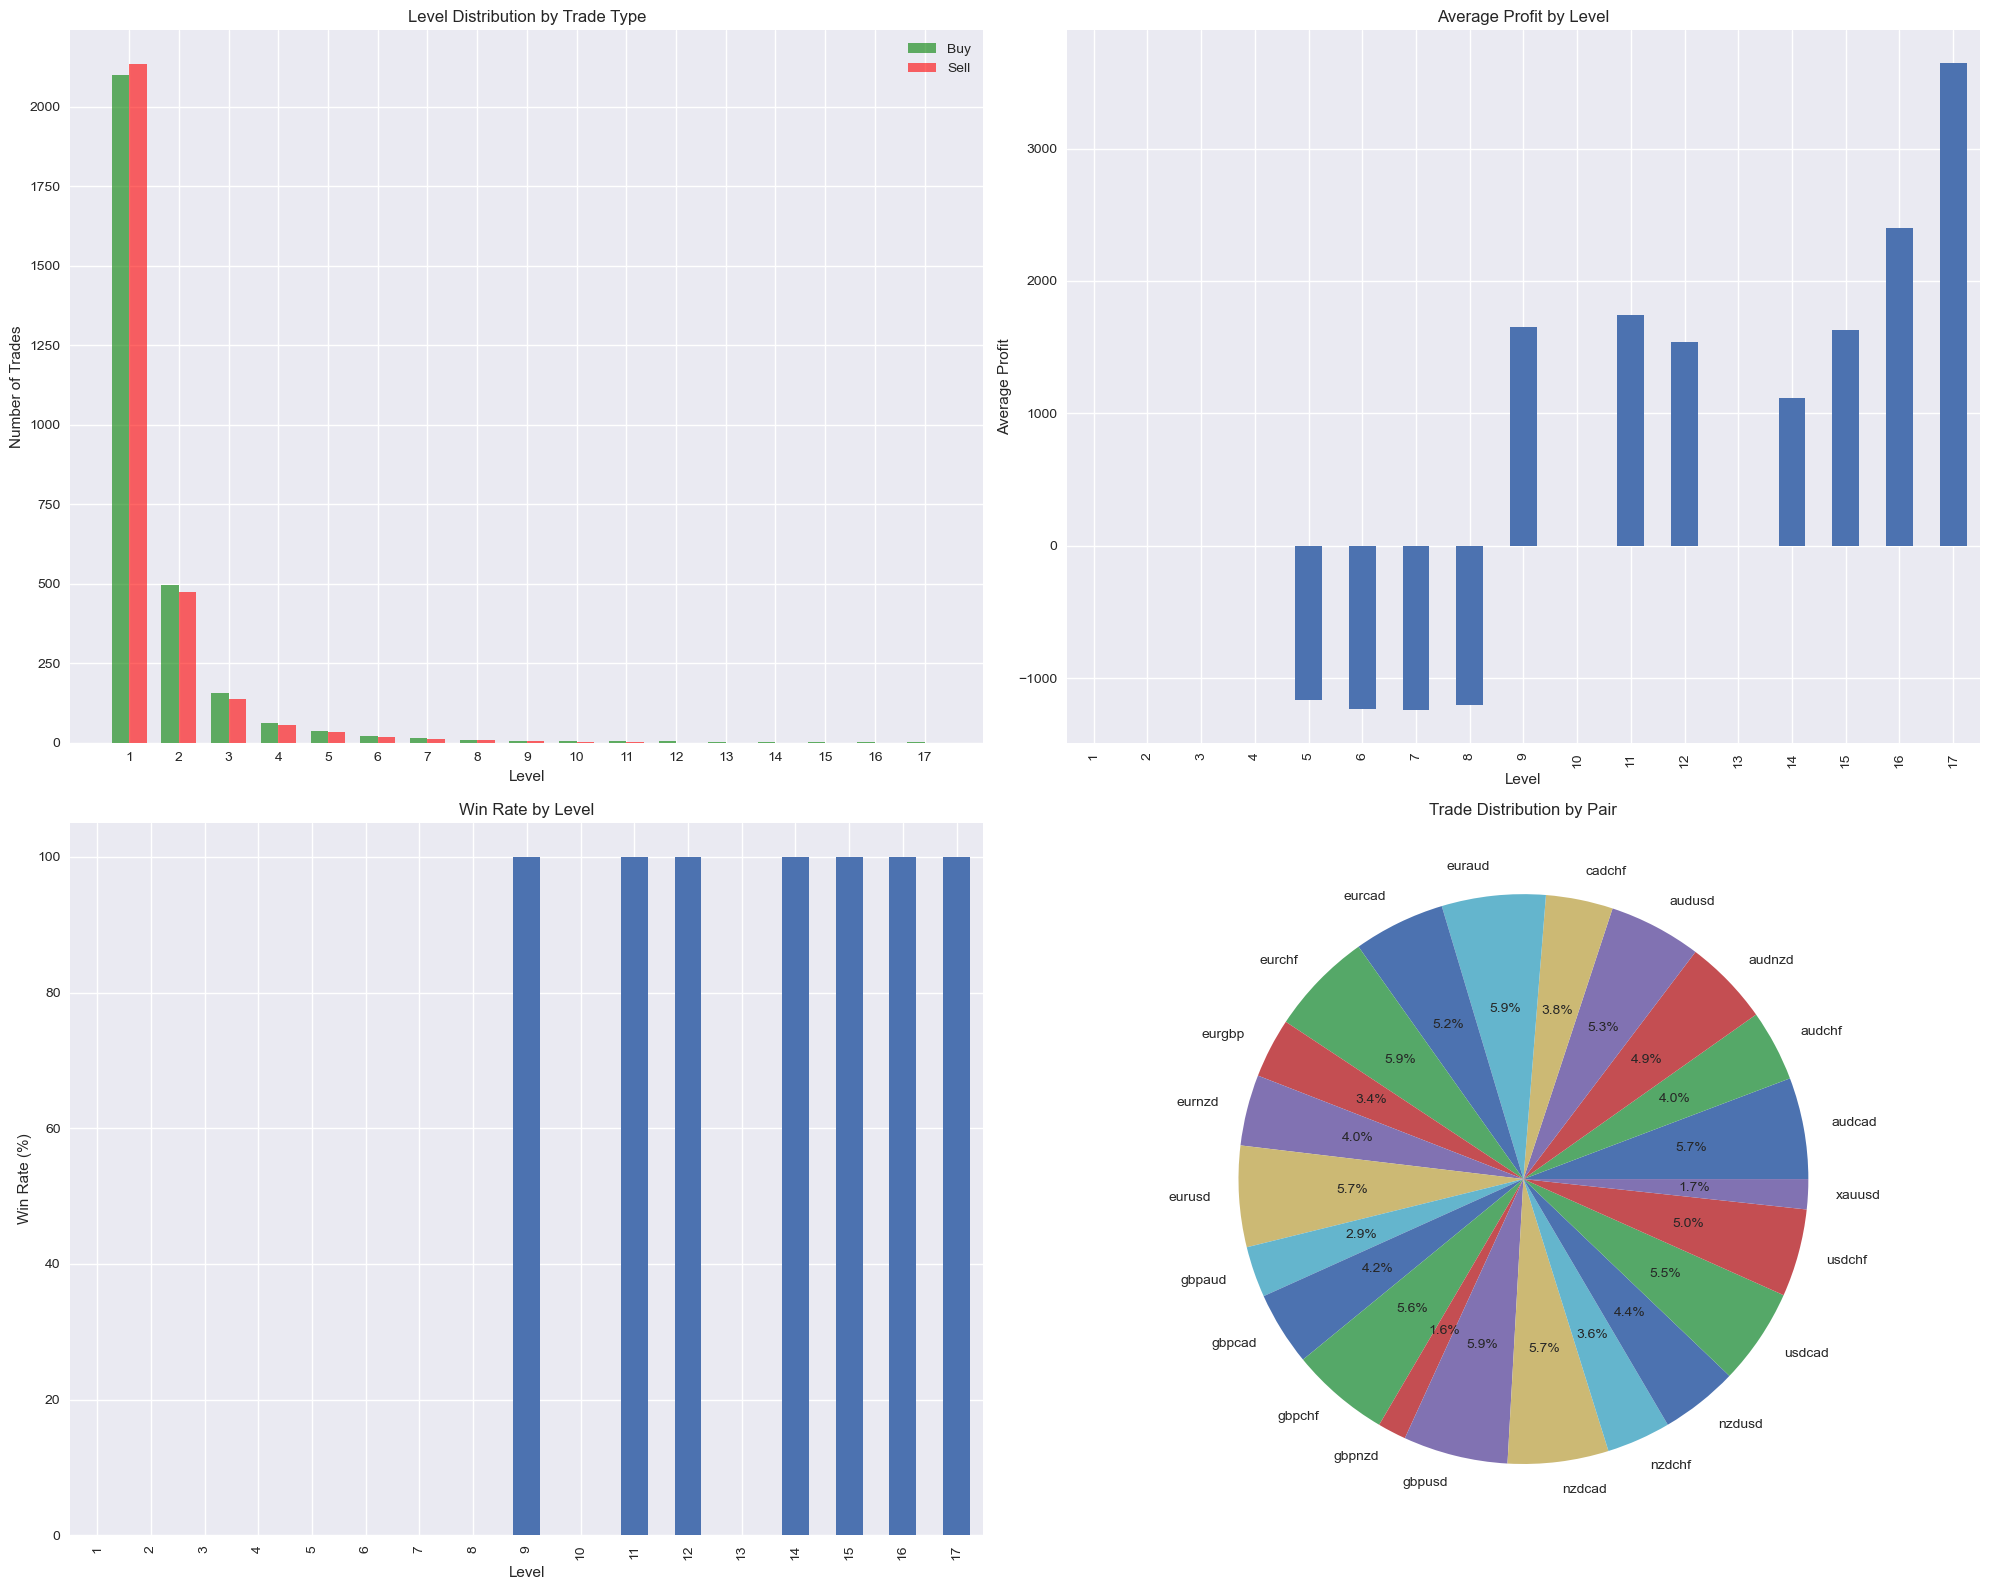

In [7]:
# Cell 4: Create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('seaborn')
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Level Distribution by Trade Type (Overall)
overall = results['OVERALL']
max_level = max(max(overall['buy_levels'].keys()), max(overall['sell_levels'].keys()))
levels = range(1, max_level + 1)

buy_counts = [overall['buy_levels'].get(level, 0) for level in levels]
sell_counts = [overall['sell_levels'].get(level, 0) for level in levels]

ax1 = axes[0, 0]
width = 0.35
x = np.arange(len(levels))
ax1.bar(x - width/2, buy_counts, width, label='Buy', color='green', alpha=0.6)
ax1.bar(x + width/2, sell_counts, width, label='Sell', color='red', alpha=0.6)
ax1.set_title('Level Distribution by Trade Type')
ax1.set_xlabel('Level')
ax1.set_ylabel('Number of Trades')
ax1.set_xticks(x)
ax1.set_xticklabels(levels)
ax1.legend()

# 2. Profit by Level
profit_by_level = pd.DataFrame()
for pair, data in results.items():
    if pair != 'OVERALL':
        profit_data = data['statistics']['profit_by_level']
        profit_data['pair'] = pair
        profit_by_level = pd.concat([profit_by_level, profit_data])

avg_profit_by_level = profit_by_level.groupby(profit_by_level.index)['mean'].mean()
ax2 = axes[0, 1]
avg_profit_by_level.plot(kind='bar', ax=ax2)
ax2.set_title('Average Profit by Level')
ax2.set_xlabel('Level')
ax2.set_ylabel('Average Profit')

# 3. Win Rate by Level
win_rate_by_level = profit_by_level[profit_by_level['sum'] > 0].groupby(level=0)['count'].sum() / \
                    profit_by_level.groupby(level=0)['count'].sum() * 100
ax3 = axes[1, 0]
win_rate_by_level.plot(kind='bar', ax=ax3)
ax3.set_title('Win Rate by Level')
ax3.set_xlabel('Level')
ax3.set_ylabel('Win Rate (%)')

# 4. Trade Distribution by Pair
pair_counts = {pair: data['statistics']['total_trades'] 
              for pair, data in results.items() 
              if pair != 'OVERALL'}
ax4 = axes[1, 1]
pd.Series(pair_counts).plot(kind='pie', ax=ax4, autopct='%1.1f%%')
ax4.set_title('Trade Distribution by Pair')

plt.tight_layout()
plt.show()